In [1]:
from general import *
from exp2 import *
import time

random_state=42
np.random.seed(random_state)

## Experiment 

In [2]:
states=['ca','il','mo','tx']
labels = ['California','Illinois','Missouri','Texas']
alpha=.1
loss='mse'
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

In [3]:
data = pd.read_csv('data/car-insurance-public/data/mo-per-zip.csv')
data.head()

,zipcode,minority,companies_name,name,bi_policy_premium,pd_policy_premium,state_risk,white_non_hisp_pct,risk_difference,combined_premium
0,63005,False,21st Century Centennial Ins Co,FARMERS INS GRP,321,211.0,216.029693,87.9,315.970307,532.0
1,63010,False,21st Century Centennial Ins Co,FARMERS INS GRP,342,192.0,251.359806,93.9,282.640194,534.0
2,63011,False,21st Century Centennial Ins Co,FARMERS INS GRP,321,211.0,225.421778,88.9,306.578222,532.0
3,63012,False,21st Century Centennial Ins Co,FARMERS INS GRP,342,192.0,210.286312,97.2,323.713688,534.0
4,63013,False,21st Century Centennial Ins Co,FARMERS INS GRP,317,141.0,158.592140,100.0,299.407860,458.0


In [4]:
pvals=[]
times=[]

for s in tqdm(states):
    data = pd.read_csv('data/car-insurance-public/data/' + s + '-per-zip.csv')

    Z = np.array(data.state_risk).reshape((-1,1))
    Y = np.array(data.combined_premium).reshape((-1,1))
    X = (1*np.array(data.minority)).reshape((-1,1))
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3, random_state=random_state)
    Z_train, Z_test, _, _ = train_test_split(Z, Y, test_size=.3, random_state=random_state)

    ###RBPT
    g1 = g()
    g1.fit(X_train, Z_train, Y_train)
    
    start_time = time.time()
    p = LogisticRegressionCV(cv=5, scoring='neg_log_loss', solver='liblinear', random_state=0).fit(Z_train, X_train.squeeze())
    H_test = np.sum(p.predict_proba(Z_test)*np.hstack((g1.predict(np.zeros(X_test.shape),Z_test).reshape(-1,1),
                                                       g1.predict(np.ones(X_test.shape),Z_test).reshape(-1,1))), axis=1).reshape(-1,1)
    pval_rbpt = get_pval_rbpt(X_test, Z_test, Y_test, H_test, g1, loss=loss)
    time_rbpt = time.time() - start_time

    ###RBPT2
    start_time = time.time()
    h = get_h(Z_train, g1.predict(X_train,Z_train).squeeze())
    pval_rbpt2 = get_pval_rbpt2(X_test, Z_test, Y_test, g1, h, loss=loss)
    time_rbpt2 = time.time() - start_time
    
    ###Storing
    times.append([time_rbpt, time_rbpt2])
    pvals.append([pval_rbpt, pval_rbpt2])
    
pvals=np.array(pvals)

100%|█████████████████████████████████████████████| 4/4 [00:45<00:00, 11.30s/it]


In [5]:
np.array(times).mean(axis=0)

array([ 0.92659545, 10.29399872])

In [6]:
pvals_rbpt = pvals[:,0]
pvals_rbpt2 = pvals[:,1]

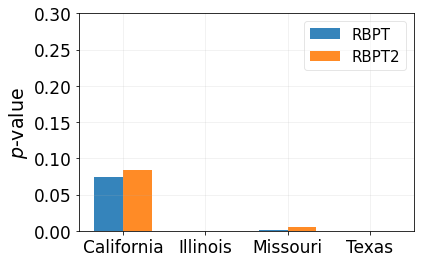

In [7]:
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

rects1 = plt.bar(x - width/2, pvals_rbpt, width, label='RBPT', color=colors[0], alpha=.9)
rects2 = plt.bar(x + width/2, pvals_rbpt2, width, label='RBPT2', color=colors[1], alpha=.9)

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('$p$-value', size=19)
plt.xticks(x, labels, fontsize=17)
plt.legend(framealpha=0.5, prop={'size': 15}) 
#plt.axhline(y=alpha, color='black', linestyle='--', lw=1, alpha=.75)
plt.yticks(fontsize=17)
plt.ylim(0,.3)
plt.grid(alpha=.2)

plt.savefig('plots/exp21_{:}.png'.format(loss), bbox_inches='tight', dpi=300, transparent=True)
plt.show()